In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from plots import histogram
from loss import total_variation
from stock_price_handler import load_stock_prices, get_log_returns
from sde import DeepSDE, BlackScholes

In [2]:
TIME_INCREMENT = 5
STOCK_NAME = "apple"
HIDDEN_SIZE = 1

In [3]:
stock_prices = load_stock_prices(STOCK_NAME)
actual_log_returns, stock_prices = get_log_returns(stock_prices)

In [4]:
sigma = np.std(actual_log_returns) / np.sqrt(TIME_INCREMENT)
mu = np.mean(actual_log_returns) / TIME_INCREMENT + np.square(sigma) / 2
initial_states = torch.tensor(np.array(stock_prices)).to(torch.float32).unsqueeze(-1)

In [5]:
times = torch.linspace(0, TIME_INCREMENT, TIME_INCREMENT)
black_scholes = BlackScholes(mu=mu, sigma=sigma, sample_size=len(actual_log_returns), times=times)
deep_sde = DeepSDE(hidden_size=HIDDEN_SIZE, mu=mu, sigma=sigma, sample_size=len(actual_log_returns), times=times)
optimizer = torch.optim.Adam(deep_sde.parameters(), lr=1e-4)

In [6]:
def train_loop(model, loss_function, optimizer, num_epochs):

    black_scholes_solution = black_scholes.solution(initial_states)
    terminal_states = black_scholes_solution[-1]
    bs_log_returns = np.log(terminal_states / initial_states.squeeze())
    loss = loss_function(bs_log_returns, torch.tensor(actual_log_returns))
    histogram(actual_log_returns, label="Actual", color="black")
    histogram(bs_log_returns.detach().numpy(), label="Black Scholes", color="blue")
    plt.title(f"Pure Black-Scholes: Loss = {loss.item():>.7f}")
    plt.legend()
    plt.show()

    model.train()
    best_loss = None
    
    for epoch in range(num_epochs):

        estimated_log_returns = model(initial_states)
        loss = loss_function(estimated_log_returns, torch.tensor(actual_log_returns))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Hidden Size = {HIDDEN_SIZE}; Epoch {epoch}: Loss = {loss.item():>.7f}")

        if best_loss is None or loss.item() < best_loss:
            best_loss = loss.item()
            histogram(actual_log_returns, label="Actual", color="black")
            histogram(estimated_log_returns.detach().numpy(), label="Neural SDE", color="orange")
            plt.title(f"Hidden Size = {HIDDEN_SIZE}; Epoch {epoch}: Loss = {loss.item():>.7f}")
            plt.legend()
            plt.show()


/Users/viviankessler/stock-sde/sde.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_states = torch.tensor(initial_states)
/var/folders/vh/mv3ytp3x2_jg2tcq53sq9f240000gn/T/ipykernel_2495/120862221.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  bs_log_returns = np.log(terminal_states / initial_states.squeeze())


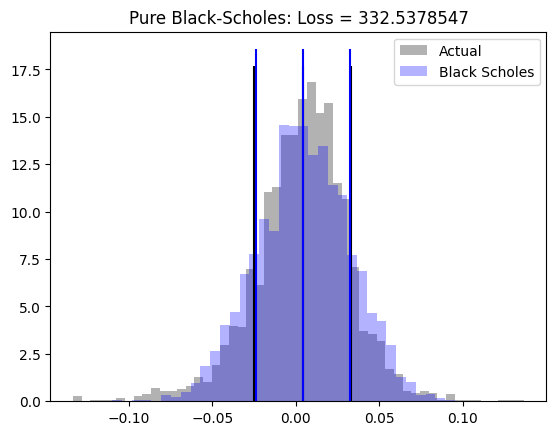

Hidden Size = 1; Epoch 0: Loss = 1046.5724580


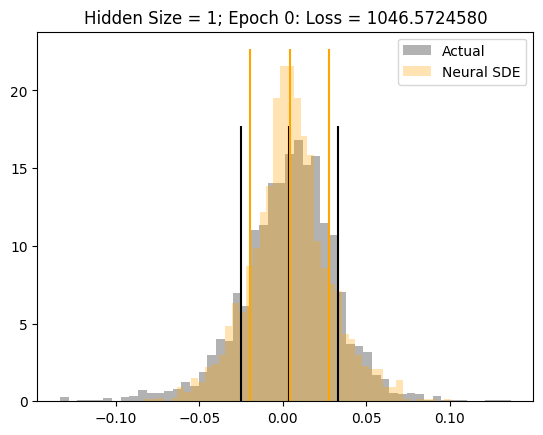

Hidden Size = 1; Epoch 1: Loss = 995.3404618


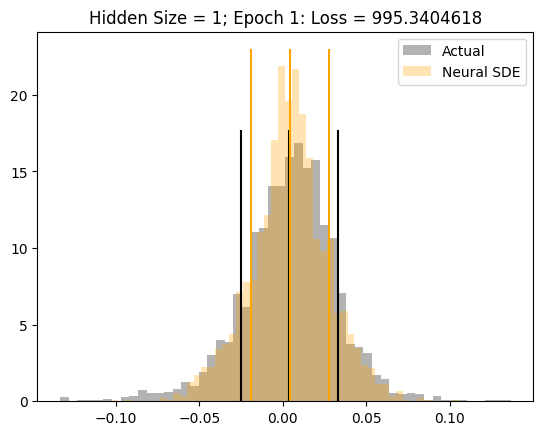

Hidden Size = 1; Epoch 2: Loss = 1271.5236986
Hidden Size = 1; Epoch 3: Loss = 659.1350858


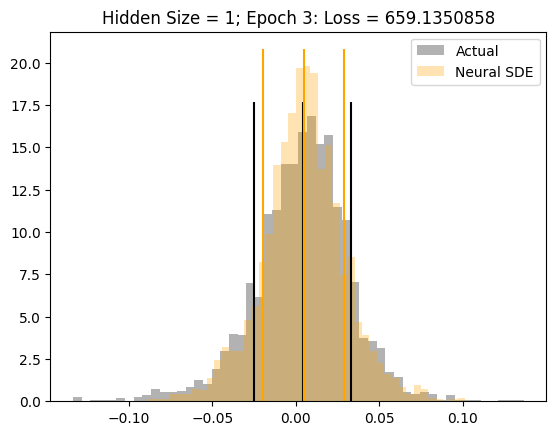

Hidden Size = 1; Epoch 4: Loss = 1200.7595806
Hidden Size = 1; Epoch 5: Loss = 919.7838011
Hidden Size = 1; Epoch 6: Loss = 883.3814477
Hidden Size = 1; Epoch 7: Loss = 874.5042222
Hidden Size = 1; Epoch 8: Loss = 634.2136583


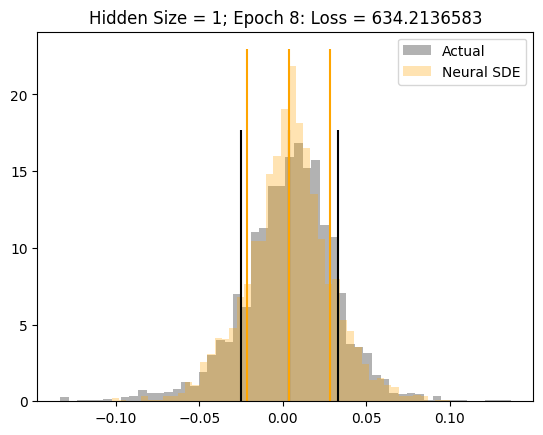

Hidden Size = 1; Epoch 9: Loss = 545.4677061


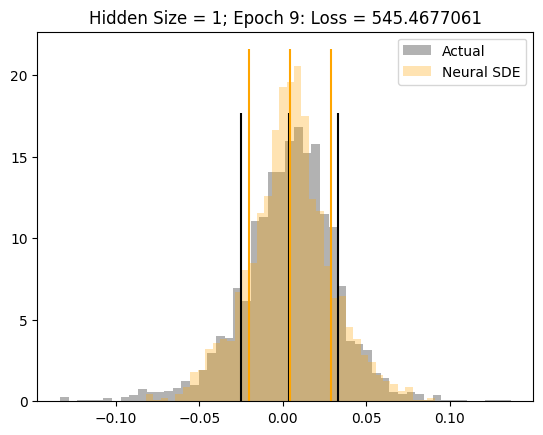

Hidden Size = 1; Epoch 10: Loss = 406.1068307


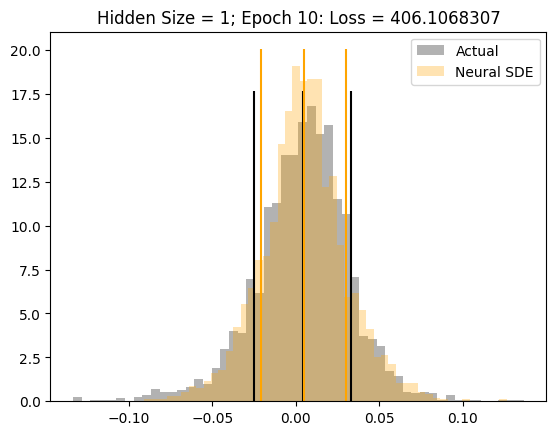

Hidden Size = 1; Epoch 11: Loss = 563.9080312
Hidden Size = 1; Epoch 12: Loss = 726.0326317
Hidden Size = 1; Epoch 13: Loss = 562.3023977
Hidden Size = 1; Epoch 14: Loss = 418.6341601
Hidden Size = 1; Epoch 15: Loss = 380.8210840


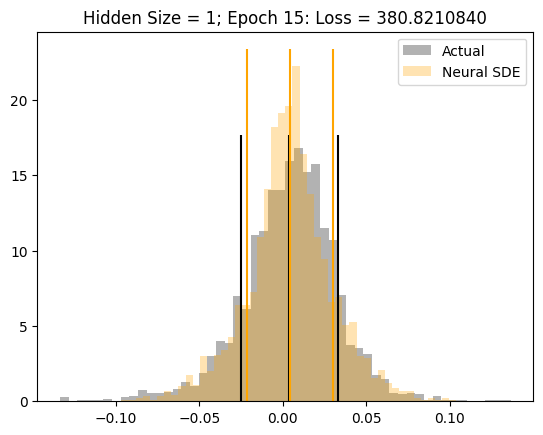

Hidden Size = 1; Epoch 16: Loss = 369.4232402


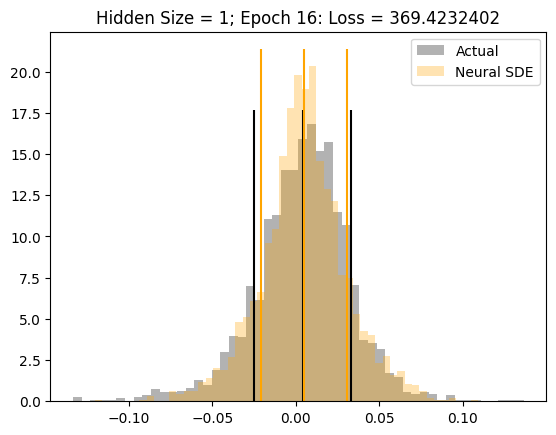

Hidden Size = 1; Epoch 17: Loss = 341.3869523


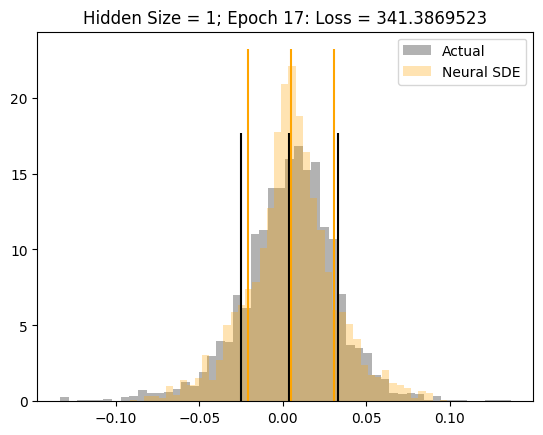

Hidden Size = 1; Epoch 18: Loss = 520.8201163
Hidden Size = 1; Epoch 19: Loss = 377.8824264
Hidden Size = 1; Epoch 20: Loss = 660.8744630
Hidden Size = 1; Epoch 21: Loss = 394.1259445
Hidden Size = 1; Epoch 22: Loss = 192.4159176


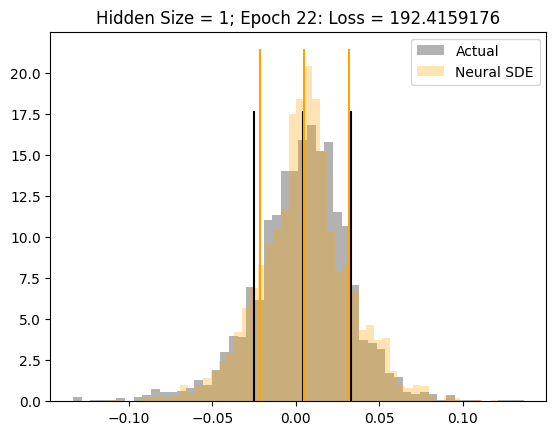

Hidden Size = 1; Epoch 23: Loss = 196.2535854
Hidden Size = 1; Epoch 24: Loss = 200.4170587
Hidden Size = 1; Epoch 25: Loss = 289.3685976
Hidden Size = 1; Epoch 26: Loss = 134.2965989


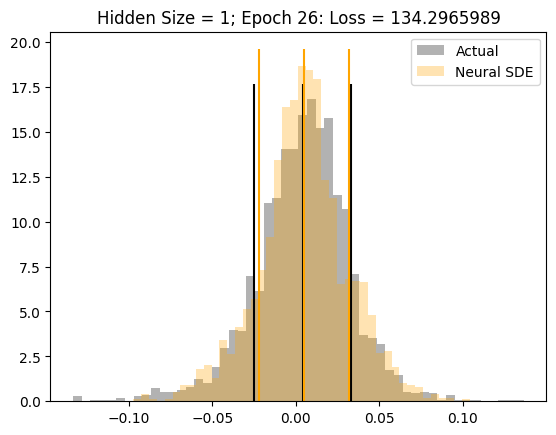

Hidden Size = 1; Epoch 27: Loss = 127.7096623


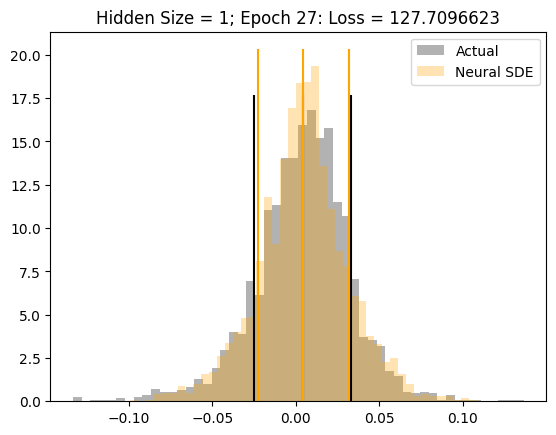

Hidden Size = 1; Epoch 28: Loss = 256.0553423
Hidden Size = 1; Epoch 29: Loss = 245.2441190
Hidden Size = 1; Epoch 30: Loss = 202.4009595
Hidden Size = 1; Epoch 31: Loss = 97.6317655


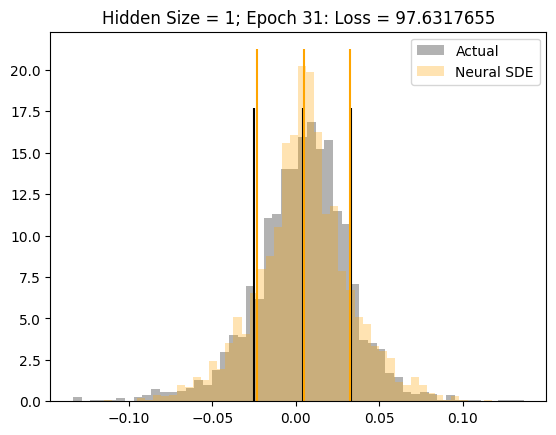

Hidden Size = 1; Epoch 32: Loss = 193.3412879
Hidden Size = 1; Epoch 33: Loss = 293.7265902
Hidden Size = 1; Epoch 34: Loss = 216.0711546
Hidden Size = 1; Epoch 35: Loss = 128.1334451
Hidden Size = 1; Epoch 36: Loss = 171.7002984
Hidden Size = 1; Epoch 37: Loss = 153.9280690
Hidden Size = 1; Epoch 38: Loss = 197.0389207
Hidden Size = 1; Epoch 39: Loss = 129.5703170
Hidden Size = 1; Epoch 40: Loss = 139.9542901
Hidden Size = 1; Epoch 41: Loss = 179.9640896
Hidden Size = 1; Epoch 42: Loss = 108.2853740
Hidden Size = 1; Epoch 43: Loss = 203.1011869
Hidden Size = 1; Epoch 44: Loss = 74.6408314


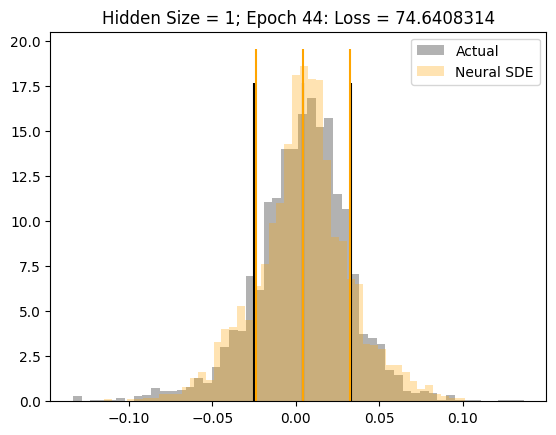

Hidden Size = 1; Epoch 45: Loss = 213.2326462
Hidden Size = 1; Epoch 46: Loss = 119.5785391
Hidden Size = 1; Epoch 47: Loss = 404.8949750
Hidden Size = 1; Epoch 48: Loss = 201.5783352
Hidden Size = 1; Epoch 49: Loss = 687.1820542
Hidden Size = 1; Epoch 50: Loss = 144.4600668
Hidden Size = 1; Epoch 51: Loss = 86.6129309
Hidden Size = 1; Epoch 52: Loss = 172.4082645
Hidden Size = 1; Epoch 53: Loss = 251.6983924
Hidden Size = 1; Epoch 54: Loss = 148.5812826
Hidden Size = 1; Epoch 55: Loss = 47.9064344


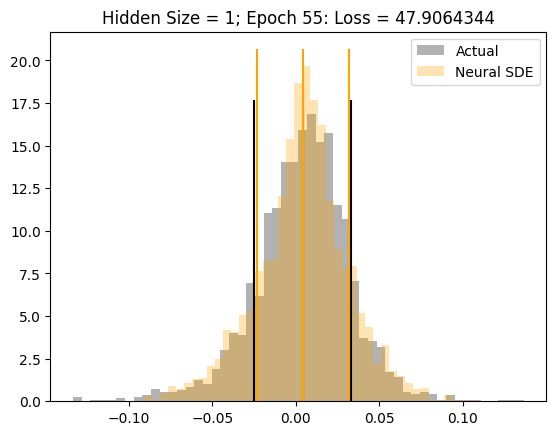

Hidden Size = 1; Epoch 56: Loss = 247.6146746
Hidden Size = 1; Epoch 57: Loss = 222.9430646
Hidden Size = 1; Epoch 58: Loss = 226.6099063
Hidden Size = 1; Epoch 59: Loss = 123.4035041
Hidden Size = 1; Epoch 60: Loss = 84.1395655
Hidden Size = 1; Epoch 61: Loss = 135.2715318
Hidden Size = 1; Epoch 62: Loss = 90.6541350
Hidden Size = 1; Epoch 63: Loss = 129.3713280
Hidden Size = 1; Epoch 64: Loss = 127.9405365
Hidden Size = 1; Epoch 65: Loss = 267.6131250
Hidden Size = 1; Epoch 66: Loss = 122.9006555
Hidden Size = 1; Epoch 67: Loss = 122.7718994
Hidden Size = 1; Epoch 68: Loss = 361.7270141
Hidden Size = 1; Epoch 69: Loss = 164.6109736
Hidden Size = 1; Epoch 70: Loss = 150.4141949
Hidden Size = 1; Epoch 71: Loss = 200.4683687
Hidden Size = 1; Epoch 72: Loss = 155.8295611
Hidden Size = 1; Epoch 73: Loss = 194.0114544
Hidden Size = 1; Epoch 74: Loss = 148.7788444
Hidden Size = 1; Epoch 75: Loss = 143.4228150
Hidden Size = 1; Epoch 76: Loss = 141.3501986
Hidden Size = 1; Epoch 77: Loss = 10

In [7]:
train_loop(deep_sde, total_variation, optimizer, 100)